# Data Mining - Assignment #2 - Clustering
### Problem B: Repeat the experiment as part A but using cosine similarity as a measure of similarity for clustering and the cost function.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import silhouette_score


### Load and merge Mnist test and train datasets:

In [75]:
mnist_test = pd.read_csv(r"mnist_test.csv", sep=",")
mnist_train = pd.read_csv(r"mnist_train.csv", sep=",")
mnist = pd.concat([mnist_train, mnist_test], ignore_index=True)
mnist.sample(20)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
4160,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57612,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59139,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18820,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19062,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41480,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50132,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34387,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23231,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28877,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### K-mean implementation using Cosine Similarity:

In [76]:
from sklearn.preprocessing import normalize

def calc_accuracy(cluster_labels, class_labels):
    cluster_stats = {}

    data = np.column_stack((cluster_labels, class_labels))

    for cluster_id, class_label in data:
        if cluster_id not in cluster_stats:
            # Initialize a Counter for each unique cluster ID
            cluster_stats[cluster_id] = Counter()
        cluster_stats[cluster_id][class_label] += 1

    # Process results
    final_results = []
    for cluster_id, counts in cluster_stats.items():
        # Most frequent class label and its count
        assigned_label, match_count = counts.most_common(1)[0]
        total_points = sum(counts.values())
        
        final_results.append({
            "cluster_id": cluster_id,
            "assigned_label": assigned_label,
            "total_points": total_points,
            "match_count": match_count,
            "accuracy": match_count/total_points
        })

    total = sum(item["accuracy"] for item in final_results)
    mean = total / len(final_results) if final_results else 0

    return mean


def IterativeKMean(features, y_true, k=10, max_iter=20, include_cost=True, include_accuracy=True, include_silhouette=True):
    results = {'cost': [], 'accuracy': [], 'silhouette': []}

    X = features
    X = normalize(X) 
    n_samples, n_features = X.shape
    
    # initialize the centroids of the cluster, pick random points of the available samples
    random_indices = np.random.choice(n_samples, k, replace=False)
    centroids = X[random_indices]

    for _ in range(max_iter):
        # Calculate Cosine Distance (1 - dot product)
        similarities = np.dot(X, centroids.T)
        distances = 1 - similarities 
        labels = np.argmin(distances, axis=1)

        # Calculate Cost (Sum of Cosine Distances)
        if include_cost:
            closest_distances = np.min(distances, axis=1)
            cost = np.sum(closest_distances)
            results['cost'].append(cost)


        # Calculate accuracy
        if include_accuracy:
            results['accuracy'].append(calc_accuracy(labels, y_true))

        # Calculate Silhouette Coefficient
        if include_silhouette:
            if len(np.unique(labels)) > 1:
                sil = silhouette_score(X, labels, sample_size=10000)
            else:
                sil = 0
            results['silhouette'].append(sil)

        # Update Centroids
        new_centroids = np.zeros((k, n_features))
        for c in range(k):
            points = X[labels == c]
            if len(points) > 0:
                mean_vec = points.mean(axis=0)
                # Re-normalize the new centroid
                norm_val = np.linalg.norm(mean_vec)
                if norm_val > 0:
                    new_centroids[c] = mean_vec / norm_val
                else:
                    new_centroids[c] = mean_vec
            else:
                new_centroids[c] = centroids[c]

        centroids = new_centroids

    return results

Convert the dataframe to arrays that the k-mean function accepts

In [77]:
# Create the labels array (y) by selecting only the label column
true_labels = mnist['label'].to_numpy()
# Create the features array (X) by dropping the label column
features = mnist.drop(columns=['label'], axis=1).to_numpy()

Run K-Mean function:

In [ ]:
k=10
max_iter=20
results = IterativeKMean(features, true_labels, k=k, max_iter=max_iter)

### 1- Generate a graph where you plot the cost function Cosine Similarity as a function of the number of iterations.

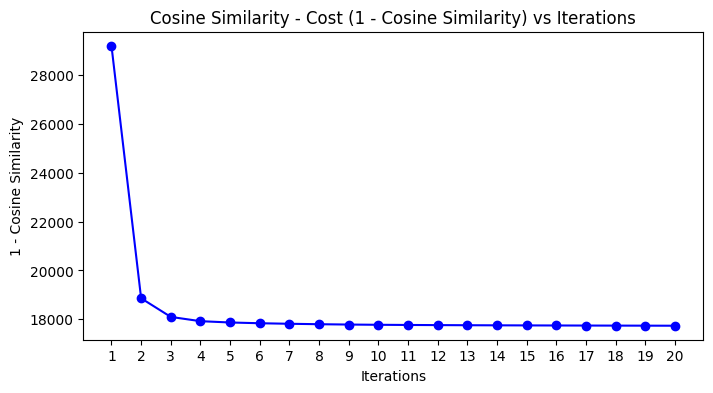

In [79]:
iterations = range(1, max_iter + 1)

# Chart 1: Cost
plt.figure(figsize=(8, 4))
plt.plot(iterations, results['cost'], 'b-o')
plt.title("Cosine Similarity - Cost (1 - Cosine Similarity) vs Iterations")
plt.ylabel("1 - Cosine Similarity")
plt.xlabel("Iterations")
plt.xticks(np.arange(1, max_iter + 1, 1)) # Set step size to 1
plt.show()

### 2- What is the percentage change in cost after 10 iterations of the K-Means algorithm

In [80]:
cost_start = results['cost'][0]
cost_iter10 = results['cost'][9]
pct_change = (cost_start - cost_iter10) / cost_iter10

print(f"Percentage Change (Iter 1 to 10): {pct_change * 100:.2f}%")

Percentage Change (Iter 1 to 10): 64.26%


### 3- Generate a graph where you plot the accuracy as a function of the number of iterations.

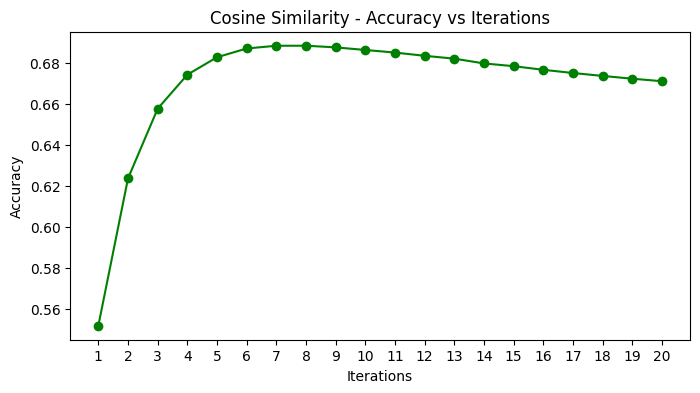

In [81]:
# Chart 2: Accuracy
plt.figure(figsize=(8, 4))
plt.plot(iterations, results['accuracy'], 'g-o')
plt.title("Cosine Similarity - Accuracy vs Iterations")
plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.xticks(np.arange(1, max_iter + 1, 1)) # Set step size to 1
plt.show()


### 4- Generate a graph where you plot the Silhouette Coefficient as a function of the number of iterations

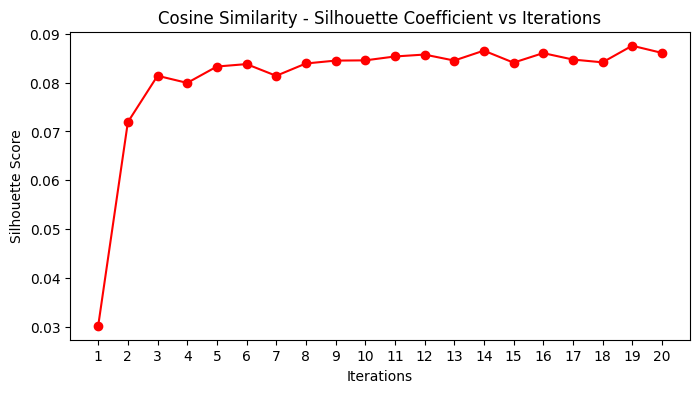

In [82]:
# Chart 3: Silhouette
plt.figure(figsize=(8, 4))
plt.plot(iterations, results['silhouette'], 'r-o')
plt.title("Cosine Similarity - Silhouette Coefficient vs Iterations")
plt.ylabel("Silhouette Score")
plt.xlabel("Iterations")
plt.xticks(np.arange(1, max_iter + 1, 1)) # Set step size to 1
plt.show()

### 5. Is Euclidean distance K-Means better than cosine similarity K-Mean in terms of cost function? Explain your reasoning.

The cost values produced by the cosine similarity cost function are much smaller than the values produced by the Euclidean distance cost function used in the first part. However, the shape of the curve plotting iteration versus the cost function is almost identical, meaning that the cost function value decreases significantly after one or two steps.
<br>In general, and For grayscale image data, Cosine Similarity is generally preferred because its cost function relies on the angle (shape/structure) of the data rather than the magnitude (brightness/intensity). Euclidean K-Means risks separating identical shapes simply because they have different pixel intensities.